In [1]:
import time 
import numpy as np
import gym
import safety_gymnasium
from pygame import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
from collections import deque
import random

In [2]:


class P3OAgent:
    def __init__(self, state_dim, action_dim, policy_net, value_net, 
                 policy_lr=3e-4, value_lr=1e-3, gamma=0.99, 
                 clip_eps=0.2, aux_coef=0.1, batch_size=64, 
                 replay_buffer_size=10000):
        self.policy_net = policy_net
        self.value_net = value_net
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=value_lr)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.aux_coef = aux_coef
        self.batch_size = batch_size
        
        self.buffer = []  # On-policy buffer
        self.replay_buffer = deque(maxlen=replay_buffer_size)  # Off-policy buffer
       
        self.state_dim = state_dim
        self.action_dim = action_dim
   
    def act(self, state):
      # Choose an action using the current policy and return its log probability.
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        policy_output = self.policy_net(state_tensor)
        action_dim = policy_output.shape[-1] // 2
        mean = policy_output[:, :action_dim]
        log_std = policy_output[:, action_dim:]
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action.squeeze(0).detach().numpy(), log_prob.squeeze(0).item()

    def store_transition(self, transition):
        #add transition to on-policy buffer
        self.buffer.append(transition)

    def compute_advantages(self, rewards, values, next_values, dones):
        #Compute generalized advantage estimates (GAE).
        advantages = []
        gae = 0
        for i in reversed(range(len(rewards))):
            td_error = rewards[i] + self.gamma * next_values[i] * (1 - dones[i]) - values[i]
            gae = td_error + self.gamma * gae
            advantages.insert(0, gae)
        return torch.tensor(advantages, dtype=torch.float32)
    
    def update_replay_buffer(self):
        self.replay_buffer.extend(self.buffer)
        self.buffer.clear()
  
    def update(self, on_policy=True):
        buffer = self.buffer if on_policy else self.replay_buffer
        if len(buffer) < self.batch_size:
            return 
        transitions = random.sample(buffer, self.batch_size)
        states, actions, rewards, dones, next_states, old_log_probs = zip(*transitions)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32)
        
        values = self.value_net(states).squeeze()
        next_values = self.value_net(next_states).squeeze()
        advantages = self.compute_advantages(rewards, values, next_values, dones).detach()
        policy_output = self.policy_net(states)
        action_dim = policy_output.shape[-1] // 2
        mean = policy_output[:, :action_dim]
        log_std = policy_output[:, action_dim:]
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        ratios = torch.exp(log_probs - old_log_probs)
        clipped_ratios = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps)
        policy_loss = -torch.min(ratios * advantages, clipped_ratios * advantages).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        self.policy_optimizer.step()

        aux_loss = nn.MSELoss()(self.value_net(states).squeeze(), -log_probs.detach())
        aux_loss *= self.aux_coef
        self.policy_optimizer.zero_grad()
        aux_loss.backward()
        self.policy_optimizer.step()

        target_values = rewards + self.gamma * next_values * (1 - dones)
        value_loss = nn.MSELoss()(self.value_net(states).squeeze(), target_values.detach())
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()


In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        return torch.cat([mean, log_std], dim=-1)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.value(x)

In [4]:
def plot_learning_curves(returns, costs, save_path=None):
    """
    Plot both the return and cost learning curves.

    Args:
        returns (list or np.ndarray): The list of episodic returns.
        costs (list or np.ndarray): The list of episodic costs.
        save_path (str, optional): File path to save the combined plot. If None, the plot will not be saved.
    """
    plt.figure(figsize=(12, 6))

    # Plot Returns
    plt.subplot(1, 2, 1)
    plt.plot(returns, label="Returns", color="green", alpha=0.8)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Learning Curve: Returns")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()

    # Plot Costs
    plt.subplot(1, 2, 2)
    plt.plot(costs, label="Costs", color="red", alpha=0.8)
    plt.xlabel("Episode")
    plt.ylabel("Cost")
    plt.title("Learning Curve: Costs")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    
    plt.show()

# helper function added for normalizing results
def normalize_data(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) if max_val != min_val else 0.5 for x in data]


Episode 1: Reward = -4.008992423147635, Cost = 0.0
Episode 2: Reward = -4.752484923583489, Cost = 116.0
Episode 3: Reward = -1.7994572077777131, Cost = 208.0
Episode 4: Reward = -3.0559716937712316, Cost = 36.0
Episode 5: Reward = -1.281746848063966, Cost = 163.0
Episode 6: Reward = -4.184093791402164, Cost = 31.0
Episode 7: Reward = -1.2705620050910515, Cost = 0.0
Episode 8: Reward = -5.606037116178823, Cost = 210.0
Episode 9: Reward = -2.2476205986498314, Cost = 243.0
Episode 10: Reward = -2.673303959093037, Cost = 202.0
Episode 11: Reward = -3.7760382283435856, Cost = 49.0
Episode 12: Reward = -1.7100603905699474, Cost = 46.0
Episode 13: Reward = -4.0884067048946235, Cost = 150.0
Episode 14: Reward = -2.7135515756181596, Cost = 127.0
Episode 15: Reward = -2.5493567926090064, Cost = 0.0
Episode 16: Reward = -2.9747185084131145, Cost = 0.0
Episode 17: Reward = -2.387032012591445, Cost = 0.0
Episode 18: Reward = -3.2794165518165377, Cost = 0.0
Episode 19: Reward = -0.9246681335500744, 

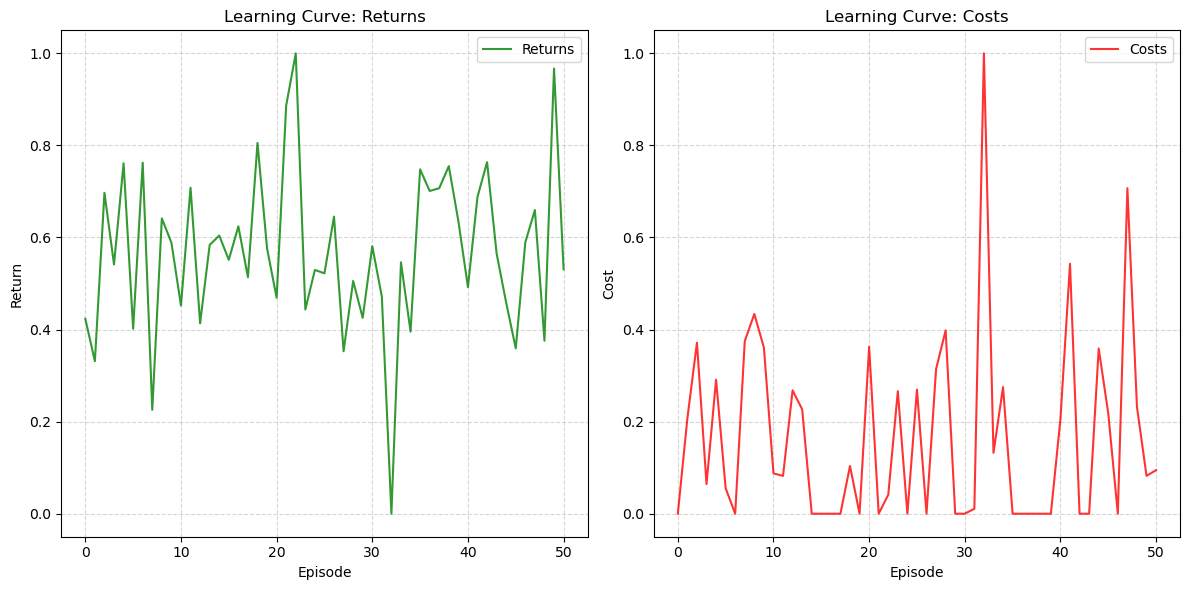

In [7]:

env_str = 'SafetyCarGoal2-v0'
env = safety_gymnasium.make(env_str,render_mode="None")
obs, info = env.reset()

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 64
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim)
value_net = ValueNetwork(state_dim, hidden_dim)

# Make Agent
agent = P3OAgent(state_dim=state_dim, action_dim=action_dim,policy_net=policy_net,value_net=value_net)

terminated, truncated = False, False
ep_ret, ep_cost = 0, 0

# learning parameters
num_episodes = 51 # 500 for final "real" episode count
max_timesteps = 5000 # 5000 for final "real" max time steps
update_frequency = 64 

off_policy_update_interval = 10
episode_rewards = []
episode_costs = []

for episode in range(num_episodes):
    obs, info = env.reset()
    ep_ret, ep_cost = 0, 0
    trajectory = []

    for t in range(max_timesteps):
        action, log_prob = agent.act(obs)
        next_obs, reward, cost, terminated, truncated, info = env.step(action)
    
        #DEBUG FLAG: original reduction is -0.01 * cost
        reward -= 0.01 * cost
        
        # Store transition in the buffer
        transition = (obs, action, reward, terminated, next_obs, log_prob)
        agent.store_transition(transition)
        # Update observation, return, cost
        ep_ret += reward
        ep_cost += cost
        obs = next_obs

        #Debug FLAG
        if t > 4990:
            print("episode probably failed to reach goal.")
            print(f"terminated: {terminated},  truncated: {truncated}")
            
        if terminated or truncated:
            break
    # record results of episode            
    episode_rewards.append(ep_ret)
    episode_costs.append(ep_cost)
    print(f"Episode {episode + 1}: Reward = {ep_ret}, Cost = {ep_cost}")

    # update agent
    if len(agent.buffer) >= update_frequency:
        agent.update()
    if episode % off_policy_update_interval == 0:
        agent.update_replay_buffer()  # Move on-policy transitions to replay buffer
        agent.update(on_policy=False)


#plt.plot(episode_rewards)
#plt.plot(norm_episode_rewards)
#plt.xlabel('Episode')
#plt.ylabel('Rewards')
#plt.show()

env.close()

# Plot Learning Curves
save_path = "learning_curves_"+ env_str + ".png"

#plot_learning_curves(episode_rewards, episode_costs, save_path=save_path)

#DEBUG FLAG: Plotting normalized data

min_ret = min(episode_rewards)
abs_min_ret = abs(min_ret)
print(f"min_ret: {min_ret},  abs_min_ret({abs_min_ret})")
fixed_norm_ep_ret = [entry + abs_min_ret for entry in episode_rewards]

min_cost = min(episode_costs)
abs_min_cost = abs(min_cost)
print(f"min_ret: {min_cost},  abs_min_cost({abs_min_cost})")
fixed_norm_ep_cost = [entry + abs_min_cost for entry in episode_costs]


norm_episode_rewards = normalize_data(fixed_norm_ep_ret)
norm_episode_costs = normalize_data(fixed_norm_ep_cost)

plot_learning_curves(norm_episode_rewards, norm_episode_costs, save_path=save_path)

torch.save(agent.policy_net.state_dict(), "p3o_policy.pth")

 #   env.viewer.clos()

In [ ]:

min_ret = min(episode_rewards)
abs_min_ret = abs(min_ret)
print(f"min_ret: {min_ret},  abs_min_ret({abs_min_ret})")
fixed_norm_ep_ret = [entry + abs_min_ret for entry in episode_rewards]

min_cost = min(episode_costs)
abs_min_cost = abs(min_cost)
print(f"min_ret: {min_cost},  abs_min_cost({abs_min_cost})")
fixed_norm_ep_cost = [entry + abs_min_cost for entry in episode_costs]


norm_episode_rewards = normalize_data(fixed_norm_ep_ret)
norm_episode_costs = normalize_data(fixed_norm_ep_cost)

plot_learning_curves(norm_episode_rewards, norm_episode_costs, save_path=save_path)

In [ ]:
min_ret = min(episode_rewards)
abs_min = abs(min_ret)
print(f"min_ret: {min_ret},  abs_min({abs_min})")

In [9]:
fixed_norm_ep_ret = [entry + abs_min for entry in episode_rewards]


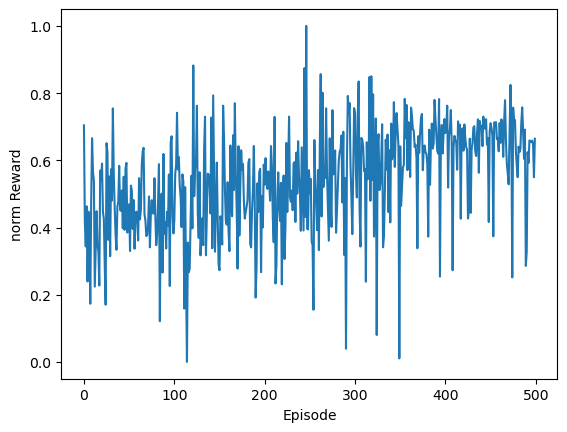

In [10]:
norm_episode_rewards = normalize_data(fixed_norm_ep_ret)
plt.plot(norm_episode_rewards)
plt.xlabel('Episode')
plt.ylabel('norm Reward')
plt.show()

In [24]:
episode_rewards_500 = episode_rewards
episode_costs_500 = episode_costs
episode_rewards = []
episode_costs = []

env_str = 'SafetyCarGoal2-v0'
env = safety_gymnasium.make(env_str,render_mode="None")
obs, info = env.reset()

def do_train():

   episode_rewards = []
   episode_costs = []
    
   for episode in range(num_episodes):
    obs, info = env.reset()
    ep_ret, ep_cost = 0, 0
    trajectory = []

    for t in range(max_timesteps):
        action, log_prob = agent.act(obs)
        next_obs, reward, cost, terminated, truncated, info = env.step(action)
    
        #DEBUG FLAG: original reduction is -0.01 * cost
        reward -= 0.01 * cost
        
        # Store transition in the buffer
        transition = (obs, action, reward, terminated, next_obs, log_prob)
        agent.store_transition(transition)
        # Update observation, return, cost
        ep_ret += reward
        ep_cost += cost
        obs = next_obs

        #Debug FLAG
        if t > 4990:
            print("episode probably failed to reach goal.")
            print(f"terminated: {terminated},  truncated: {truncated}")
            
        if terminated or truncated:
            break
    # record results of episode            
    episode_rewards.append(ep_ret)
    episode_costs.append(ep_cost)
    print(f"Episode {episode + 1}: Reward = {ep_ret}, Cost = {ep_cost}")

    # update agent
    if len(agent.buffer) >= update_frequency:
        agent.update()
    if episode % off_policy_update_interval == 0:
        agent.update_replay_buffer()  # Move on-policy transitions to replay buffer
        agent.update(on_policy=False)


Plot saved to learning_curves_SafetyCarGoal2-v0_1000.png


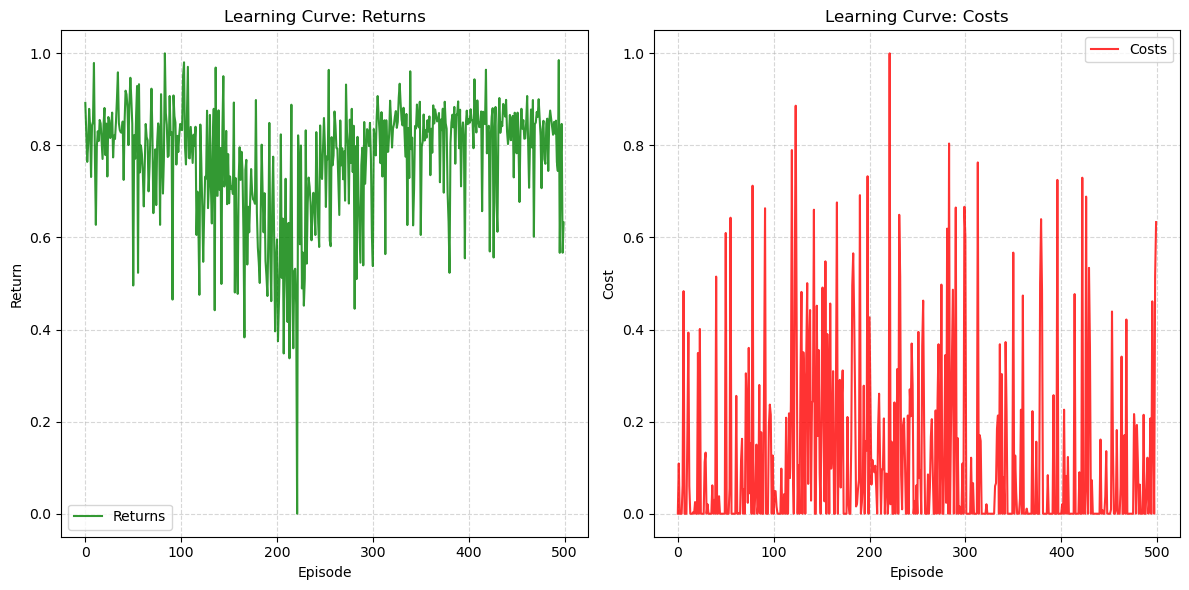

In [18]:
do_train()

episode_rewards_1000 = episode_rewards
episode_costs_1000 = episode_costs

norm_episode_rewards_1000 = normalize_data(episode_rewards_1000)
norm_episode_costs_1000 = normalize_data(episode_costs_1000)

save_path = "learning_curves_"+ env_str + "_1000.png"

plot_learning_curves(norm_episode_rewards_1000, norm_episode_costs_1000, save_path=save_path)


Episode 1: Reward = -0.5059139847910215, Cost = 20.0
Episode 2: Reward = 0.03990528352359002, Cost = 0.0
Episode 3: Reward = -2.1040281613894596, Cost = 76.0
Episode 4: Reward = 0.014337267507670781, Cost = 59.0
Episode 5: Reward = 0.3205396656528603, Cost = 0.0
Episode 6: Reward = -2.259732747794809, Cost = 308.0
Episode 7: Reward = -0.3607931142658145, Cost = 27.0
Episode 8: Reward = 0.11071947978406271, Cost = 0.0
Episode 9: Reward = -0.42693982067411373, Cost = 0.0
Episode 10: Reward = -2.5025986868509587, Cost = 59.0
Episode 11: Reward = 0.1778177818992155, Cost = 0.0
Episode 12: Reward = -0.12056204412047045, Cost = 0.0
Episode 13: Reward = 2.2202440474812906, Cost = 0.0
Episode 14: Reward = -0.35502106356033236, Cost = 0.0
Episode 15: Reward = -0.1931034960575846, Cost = 0.0
Episode 16: Reward = -0.45849217807480436, Cost = 0.0
Episode 17: Reward = 0.6706177231887678, Cost = 0.0
Episode 18: Reward = -0.3395389033912022, Cost = 0.0
Episode 19: Reward = -0.17430957179905082, Cost 

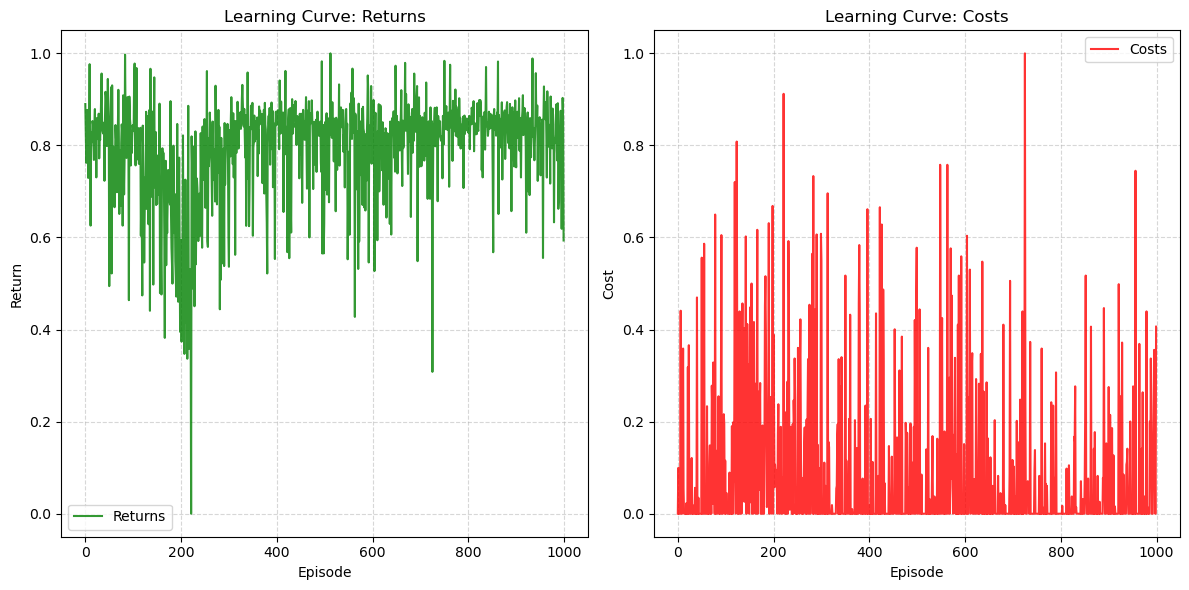

In [19]:
do_train()

episode_rewards_1500 = episode_rewards
episode_costs_1500 = episode_costs

norm_episode_rewards_1500 = normalize_data(episode_rewards_1500)
norm_episode_costs_1500 = normalize_data(episode_costs_1500)

save_path = "learning_curves_"+ env_str + "_1500.png"

plot_learning_curves(norm_episode_rewards_1500, norm_episode_costs_1500, save_path=save_path)
